In [1]:
import pandas as pd
fish  = pd.read_csv('https://bit.ly/fish_csv_data')

In [2]:
fish.head()

,Species,Weight,Length,Diagonal,Height,Width
0,Bream,242.0,25.4,30.0,11.5200,4.0200
1,Bream,290.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,26.5,31.1,12.3778,4.6961
3,Bream,363.0,29.0,33.5,12.7300,4.4555
4,Bream,430.0,29.0,34.0,12.4440,5.1340


In [3]:
X = fish[['Weight', 'Length', 'Diagonal',  'Height', 'Width']].to_numpy()
y = fish['Species'].to_numpy()


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((119, 5), (119,), (40, 5), (40,))

Đoạn mã này sử dụng StandardScaler từ thư viện sklearn.preprocessing để chuẩn hóa dữ liệu đầu vào. Dưới đây là giải thích chi tiết:  
- Import thư viện: StandardScaler được sử dụng để chuẩn hóa dữ liệu bằng cách loại bỏ giá trị trung bình và chia dữ liệu theo độ lệch chuẩn (z-score normalization).  
- Khởi tạo scaler: scaler = StandardScaler() tạo một đối tượng StandardScaler để thực hiện chuẩn hóa.  
- Tính toán thông số từ dữ liệu huấn luyện: scaler.fit(X_train) tính toán giá trị trung bình (mean) và độ lệch chuẩn (std) của từng đặc trưng (feature) trong tập dữ liệu huấn luyện X_train. Các thông số này sẽ được lưu trong scaler để áp dụng cho cả tập huấn luyện và tập kiểm tra.  
- Chuẩn hóa tập huấn luyện: X_train_scaled = scaler.transform(X_train) áp dụng chuẩn hóa cho tập huấn luyện. Công thức chuẩn hóa: [ z = \frac{x - \mu}{\sigma} ] Trong đó:  
    - (x): giá trị của đặc trưng.
    - (\mu): giá trị trung bình của đặc trưng.
    - (\sigma): độ lệch chuẩn của đặc trưng.
- Chuẩn hóa tập kiểm tra: X_test_scaled = scaler.transform(X_test) áp dụng cùng một phép chuẩn hóa (sử dụng (\mu) và (\sigma) từ tập huấn luyện) cho tập kiểm tra X_test. Điều này đảm bảo tính nhất quán giữa hai tập dữ liệu. 

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [6]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss='log_loss', max_iter=1000, random_state=42) # max_iter는 수행할 에포크 횟수를 지정한다.
sgd_clf.fit(X_train_scaled, y_train)

print(sgd_clf.score(X_train_scaled, y_train))
print(sgd_clf.score(X_test_scaled, y_test))

0.8739495798319328
0.8


In [7]:
sgd_clf.partial_fit(X_train_scaled, y_train) # partial_fit은 SGDClassifier의 fit 메서드와 유사하지만, 이전에 학습한 모델을 계속 업데이트할 수 있다.

print(sgd_clf.score(X_train_scaled, y_train))
print(sgd_clf.score(X_test_scaled, y_test))

0.8907563025210085
0.925


### 아쉽지만 SGDClassifier는 미니배치 경사 하강법이나 미니배치 SGD를 지원하지 않는다.

## 에포크와 과대/과소적합
확률적 경사 하강법을 사용한 모델은 에포크 횟수에 따라 과소적합이나 과대적합이 될 수 있습니다. 에포크 횟수가 적으면 모델이 훈련 세트를 덜 학습합니다. 에포크 횟수가 충분히 많으면 훈련 세트를 완전히 학습할 것 입니다. 훈련 세트에 아주 잘 맞는 모델이 만들어집니다.

적은 에포크 횟수는 훈련 세트와 테스트 세트에 잘 맞지 않는 과소적합, 많은 에포크 횟수는 훈련 세트에 너무 잘 맞아 테스트 세트에서 점수가 나쁜 과대적합 모델일 가능성이 높습니다.

<img src="https://devmjun.github.io/assets/post_img/posts/01_alone_ml/alone_ml_chapter4-02.png">

에포크가 진행됨에 따라 훈련 세트 점수는 꾸준히 증가하지만 테스트 세트 점수는 어느 순간 감소하기 시작합니다. 바로 이 지점이 모델이 과대적합되기 시작하는 곳입니다. 과대적합이 시작하기 전에 훈련을 멈추는 것을 조기 종료(early stopping) 라고 합니다.

In [8]:
import numpy as np

sgd_clf = SGDClassifier(loss="log_loss", random_state=42)
train_scores = []
test_scores = []
classes = np.unique(y_train)


In [9]:
for _ in range(0, 300):
    sgd_clf.partial_fit(X_train_scaled, y_train, classes=classes)
    train_scores.append(sgd_clf.score(X_train_scaled, y_train))
    test_scores.append(sgd_clf.score(X_test_scaled, y_test))    
    

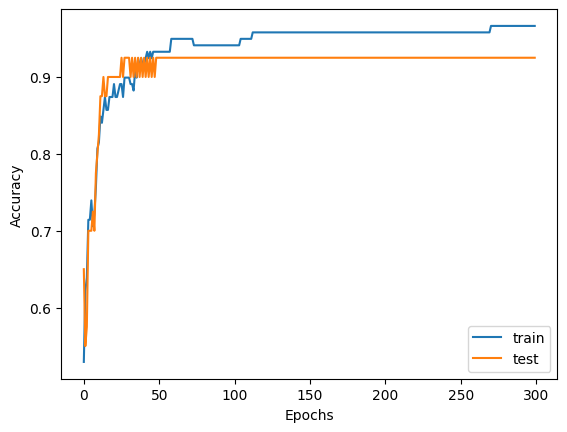

In [10]:
import matplotlib.pyplot as plt
plt.plot(train_scores, label='train')
plt.plot(test_scores, label='test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

### epoch 100번부터 훈련 세트와 테스트 세트의 점수가 조금식 벌우지고 있다.

In [11]:
sgd_clf = SGDClassifier(loss="log_loss", random_state=42, max_iter=100, tol=None)
sgd_clf.fit(X_train_scaled, y_train)
print(sgd_clf.score(X_train_scaled, y_train))
print(sgd_clf.score(X_test_scaled, y_test))

0.957983193277311
0.925


### SGDClassifier는 일정 에포크 동안 성능이 향상되지 않으면 더 훈련하지 않고 자동으로 멈춥니다.
    - tol 매개번수 None은 훈련이 멈추지 않도록 합니다.


- 힌지 손실(Hinge Loss)은 주로 **서포트 벡터 머신(SVM)**에서 사용되는 손실 함수로, 이진 분류 문제에서 사용됩니다. 힌지 손실은 모델이 예측한 값과 실제 레이블 간의 차이를 측정하며, 마진(margin)을 최대화하는 데 초점을 둡니다. 

In [12]:
sgd_clf = SGDClassifier(loss="hinge", random_state=42, max_iter=100, tol=None)

sgd_clf.fit(X_train_scaled, y_train)
print(sgd_clf.score(X_train_scaled, y_train))
print(sgd_clf.score(X_test_scaled, y_test))


0.9495798319327731
0.925


# 4장의 정리 내용

In [13]:
from IPython.display import HTML

HTML('''
<div style="display: flex; justify-content: center; align-items: center; height: 700px;">
  <iframe src="https://maxo.tistory.com/64" width="1920" height="1080" style="border: none;"></iframe>
</div>
''')
